# The goal of this notebook is to create a dataset that combines multiple data sources. It starts from the us midwest fields dataset and than adds vegetation indices, dem data, soils composition data and meterological data.

## import libraries

In [74]:
import rasterio
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import pyodbc
import os
import numpy

## loading us midwest fields dataset

In [75]:
# data are taken from https://figshare.com/articles/dataset/Data_for_Multi-site_evaluation_of_stratified_and_balanced_sampling_of_soil_organic_carbon_stocks_in_agricultural_fields_/23669304
ds = pd.read_csv('data/U.S. Midwest fields/measurements.csv')

ds

,site,location_id,sample_depth_min,sample_depth_max,SOCc,BD
0,NE,101A0001,0,5.0,2.039450,1.335931
1,NE,101A0001,5,15.0,1.725364,1.512957
2,NE,101A0001,15,30.0,1.678135,1.244744
3,NE,101A0001,30,60.0,1.076969,1.391142
4,NE,101A0001,60,90.0,0.553813,1.471202
...,...,...,...,...,...,...
3972,IL-RT,RT-M17,30,60.0,1.010000,1.200786
3973,IL-RT,RT-M18,0,30.0,1.060000,1.279252
3974,IL-RT,RT-M18,30,60.0,0.600000,1.168117
3975,IL-RT,RT-M19,0,30.0,1.450000,1.134687


In [76]:
ds_loc = pd.read_csv('data/U.S. Midwest fields/locations.csv')

ds_loc

,site,location_id,X,Y
0,NE,101A0003,-96.454699,41.152080
1,NE,101A0005,-96.454464,41.151848
2,NE,101A0006,-96.454460,41.151740
3,NE,101A0001,-96.454484,41.152296
4,NE,101A0004,-96.454372,41.151906
...,...,...,...,...
1165,IL-RT,RT-M5,-88.156262,39.885019
1166,IL-RT,RT-M6,-88.156260,39.884686
1167,IL-RT,RT-M7,-88.156261,39.884352
1168,IL-RT,RT-M8,-88.156258,39.884017


In [77]:
# joining the two datasets

x = []
y = []

for index, row in ds.iterrows():
    join_row = ds_loc[ds_loc['site'] == row['site']]
    join_row = join_row[join_row['location_id'] == row['location_id']]
    x.append(join_row['X'].iloc[0])
    y.append(join_row['Y'].iloc[0])

ds['X'] = x
ds['Y'] = y

ds

,site,location_id,sample_depth_min,sample_depth_max,SOCc,BD,X,Y
0,NE,101A0001,0,5.0,2.039450,1.335931,-96.454484,41.152296
1,NE,101A0001,5,15.0,1.725364,1.512957,-96.454484,41.152296
2,NE,101A0001,15,30.0,1.678135,1.244744,-96.454484,41.152296
3,NE,101A0001,30,60.0,1.076969,1.391142,-96.454484,41.152296
4,NE,101A0001,60,90.0,0.553813,1.471202,-96.454484,41.152296
...,...,...,...,...,...,...,...,...
3972,IL-RT,RT-M17,30,60.0,1.010000,1.200786,-88.156249,39.881002
3973,IL-RT,RT-M18,0,30.0,1.060000,1.279252,-88.156247,39.880660
3974,IL-RT,RT-M18,30,60.0,0.600000,1.168117,-88.156247,39.880660
3975,IL-RT,RT-M19,0,30.0,1.450000,1.134687,-88.156246,39.880319


## the images and the dem data of the fields are downloaded from sentinel-2 through sentinel-hub package

## calculating vegetation indices

In [78]:
data = {}

for field in list(set(ds['site'])):
    data[field] = {}
    found = False
    for mounth in os.listdir('data/U.S. Midwest fields/immagini/' + field):
        raster = rasterio.open('data/U.S. Midwest fields/immagini/' + field + '/' + mounth + '/response.tiff')

        blue = numpy.array(raster.read(2), dtype=numpy.float64) / 10000
        green = numpy.array(raster.read(3), dtype=numpy.float64) / 10000
        red = numpy.array(raster.read(4), dtype=numpy.float64) / 10000
        nir = numpy.array(raster.read(8), dtype=numpy.float64) / 10000

        ndvi = (nir - red) / (nir + red)
        evi = 2.5 * (nir - red) / ((nir + 6.0 * red - 7.5 * blue) + 1.0)
        evi2 = 2.4 * (nir - red) / (nir + red + 1.0)
        gndvi = (nir - green) / (nir + green)
        savi = (nir - red) / (nir + red + 0.428) * (1.0 + 0.428)
        ndwi = (green - nir) / (green + nir)

        if not found:
            data[field]['ndvi'] = numpy.array(ndvi)
            data[field]['evi'] = numpy.array(evi)
            data[field]['evi2'] = numpy.array(evi2)
            data[field]['gndvi'] = numpy.array(gndvi)
            data[field]['savi'] = numpy.array(savi)
            data[field]['ndwi'] = numpy.array(ndwi)
            found = True
        else:
            data[field]['ndvi'] += ndvi
            data[field]['evi'] += evi
            data[field]['evi2'] += evi2
            data[field]['gndvi'] += gndvi
            data[field]['savi'] += savi
            data[field]['ndwi'] += ndwi

        raster.close()

for field in data:
    for index in data[field]:
        data[field][index] /= 12
        print(field, index, data[field][index].shape)

NE ndvi (1974, 992)
NE evi (1974, 992)
NE evi2 (1974, 992)
NE gndvi (1974, 992)
NE savi (1974, 992)
NE ndwi (1974, 992)
IL-RS ndvi (1631, 2371)
IL-RS evi (1631, 2371)
IL-RS evi2 (1631, 2371)
IL-RS gndvi (1631, 2371)
IL-RS savi (1631, 2371)
IL-RS ndwi (1631, 2371)
IL-DG ndvi (1922, 1527)
IL-DG evi (1922, 1527)
IL-DG evi2 (1922, 1527)
IL-DG gndvi (1922, 1527)
IL-DG savi (1922, 1527)
IL-DG ndwi (1922, 1527)
IL-MC ndvi (1338, 2175)
IL-MC evi (1338, 2175)
IL-MC evi2 (1338, 2175)
IL-MC gndvi (1338, 2175)
IL-MC savi (1338, 2175)
IL-MC ndwi (1338, 2175)
IL-RD ndvi (1633, 2374)
IL-RD evi (1633, 2374)
IL-RD evi2 (1633, 2374)
IL-RD gndvi (1633, 2374)
IL-RD savi (1633, 2374)
IL-RD ndwi (1633, 2374)
IL-RT ndvi (2201, 1525)
IL-RT evi (2201, 1525)
IL-RT evi2 (2201, 1525)
IL-RT gndvi (2201, 1525)
IL-RT savi (2201, 1525)
IL-RT ndwi (2201, 1525)
IL-BR ndvi (1448, 1904)
IL-BR evi (1448, 1904)
IL-BR evi2 (1448, 1904)
IL-BR gndvi (1448, 1904)
IL-BR savi (1448, 1904)
IL-BR ndwi (1448, 1904)
IL-PT ndvi (1631

## adding vegetation indices

In [79]:
ndvi_means = []
evi_means = []
evi2_means = []
gndvi_means = []
savi_means = []
ndwi_means = []

for _, row in ds.iterrows():

    raster = rasterio.open('data/U.S. Midwest fields/immagini/' + row['site'] + '/' +
        os.listdir('data/U.S. Midwest fields/immagini/' + row['site'])[0] + '/response.tiff')

    x = row['X']
    y = row['Y']
    x_raster, y_raster = raster.index(x, y)

    ndvi_means.append(data[row['site']]['ndvi'][x_raster][y_raster])
    evi_means.append(data[row['site']]['evi'][x_raster][y_raster])
    evi2_means.append(data[row['site']]['evi2'][x_raster][y_raster])
    gndvi_means.append(data[row['site']]['gndvi'][x_raster][y_raster])
    savi_means.append(data[row['site']]['savi'][x_raster][y_raster])
    ndwi_means.append(data[row['site']]['ndwi'][x_raster][y_raster])

    raster.close()

ds['ndvi_mean'] = ndvi_means
ds['evi_mean'] = evi_means
ds['evi2_mean'] = evi2_means
ds['gndvi_mean'] = gndvi_means
ds['savi_mean'] = savi_means
ds['ndwi_mean'] = ndwi_means

ds

,site,location_id,sample_depth_min,sample_depth_max,SOCc,BD,X,Y,ndvi_mean,evi_mean,evi2_mean,gndvi_mean,savi_mean,ndwi_mean
0,NE,101A0001,0,5.0,2.039450,1.335931,-96.454484,41.152296,0.379356,0.251904,0.248457,0.452170,0.251763,-0.452170
1,NE,101A0001,5,15.0,1.725364,1.512957,-96.454484,41.152296,0.379356,0.251904,0.248457,0.452170,0.251763,-0.452170
2,NE,101A0001,15,30.0,1.678135,1.244744,-96.454484,41.152296,0.379356,0.251904,0.248457,0.452170,0.251763,-0.452170
3,NE,101A0001,30,60.0,1.076969,1.391142,-96.454484,41.152296,0.379356,0.251904,0.248457,0.452170,0.251763,-0.452170
4,NE,101A0001,60,90.0,0.553813,1.471202,-96.454484,41.152296,0.379356,0.251904,0.248457,0.452170,0.251763,-0.452170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3972,IL-RT,RT-M17,30,60.0,1.010000,1.200786,-88.156249,39.881002,0.348865,0.253205,0.226801,0.454580,0.227588,-0.454580
3973,IL-RT,RT-M18,0,30.0,1.060000,1.279252,-88.156247,39.880660,0.339349,0.251926,0.226372,0.437176,0.226358,-0.437176
3974,IL-RT,RT-M18,30,60.0,0.600000,1.168117,-88.156247,39.880660,0.339349,0.251926,0.226372,0.437176,0.226358,-0.437176
3975,IL-RT,RT-M19,0,30.0,1.450000,1.134687,-88.156246,39.880319,0.339473,0.230769,0.204752,0.438321,0.209036,-0.438321


## adding dem data

In [80]:
dem = []

for _, row in ds.iterrows():

    raster = rasterio.open('data/U.S. Midwest fields/dem/' + row['site'] + '/response.tiff')
    band = numpy.array(raster.read(1), dtype=numpy.float64)

    x = row['X']
    y = row['Y']
    
    x_raster, y_raster = raster.index(x, y)

    dem.append(band[x_raster][y_raster])

    raster.close()

ds['dem'] = dem

ds

,site,location_id,sample_depth_min,sample_depth_max,SOCc,BD,X,Y,ndvi_mean,evi_mean,evi2_mean,gndvi_mean,savi_mean,ndwi_mean,dem
0,NE,101A0001,0,5.0,2.039450,1.335931,-96.454484,41.152296,0.379356,0.251904,0.248457,0.452170,0.251763,-0.452170,353.0
1,NE,101A0001,5,15.0,1.725364,1.512957,-96.454484,41.152296,0.379356,0.251904,0.248457,0.452170,0.251763,-0.452170,353.0
2,NE,101A0001,15,30.0,1.678135,1.244744,-96.454484,41.152296,0.379356,0.251904,0.248457,0.452170,0.251763,-0.452170,353.0
3,NE,101A0001,30,60.0,1.076969,1.391142,-96.454484,41.152296,0.379356,0.251904,0.248457,0.452170,0.251763,-0.452170,353.0
4,NE,101A0001,60,90.0,0.553813,1.471202,-96.454484,41.152296,0.379356,0.251904,0.248457,0.452170,0.251763,-0.452170,353.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3972,IL-RT,RT-M17,30,60.0,1.010000,1.200786,-88.156249,39.881002,0.348865,0.253205,0.226801,0.454580,0.227588,-0.454580,198.0
3973,IL-RT,RT-M18,0,30.0,1.060000,1.279252,-88.156247,39.880660,0.339349,0.251926,0.226372,0.437176,0.226358,-0.437176,198.0
3974,IL-RT,RT-M18,30,60.0,0.600000,1.168117,-88.156247,39.880660,0.339349,0.251926,0.226372,0.437176,0.226358,-0.437176,198.0
3975,IL-RT,RT-M19,0,30.0,1.450000,1.134687,-88.156246,39.880319,0.339473,0.230769,0.204752,0.438321,0.209036,-0.438321,198.0


## adding harmonized world soil database

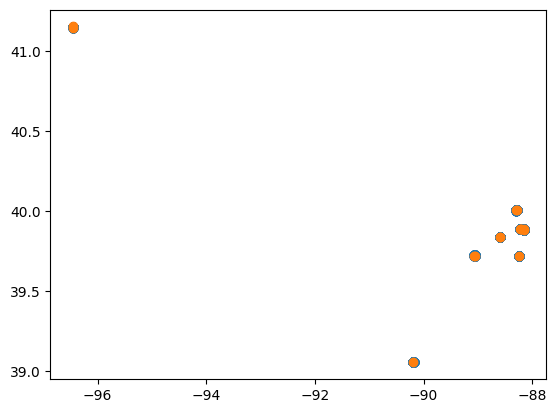

In [81]:
# data are taken from https://www.fao.org/soils-portal/soil-survey/soil-maps-and-databases/harmonized-world-soil-database-v12/en/
raster = rasterio.open("data/fao/hwsd/HWSD_RASTER/hwsd.bil")

points = set()

for index, row in ds.iterrows():
    x = float(row['X'])
    y = float(row['Y'])

    x_raster, y_raster = raster.index(x, y)

    points.add((x_raster, y_raster))

x = [raster.xy(elem[0], elem[1])[0] for elem in points]
y = [raster.xy(elem[0], elem[1])[1] for elem in points]

plt.scatter(ds['X'], ds['Y'])
plt.scatter(x, y)

In [82]:
MDB = 'data/fao/hwsd/HWSD.mdb'
DRV = '{Microsoft Access Driver (*.mdb, *.accdb)}'

con = pyodbc.connect('DRIVER={};DBQ={}'.format(DRV,MDB))
cur = con.cursor()
rows = cur.execute('SELECT * FROM HWSD_DATA;').fetchall()

columns = [column[0] for column in cur.description]

cur.close()
con.close()

df_soil = pd.DataFrame((tuple(t) for t in rows))
df_soil.columns = columns

df_soil

,ID,MU_GLOBAL,MU_SOURCE1,MU_SOURCE2,ISSOIL,SHARE,SEQ,SU_SYM74,SU_CODE74,SU_SYM85,...,S_OC,S_PH_H2O,S_CEC_CLAY,S_CEC_SOIL,S_BS,S_TEB,S_CACO3,S_CASO4,S_ESP,S_ECE
0,2,7002,2,2.0,0,100.0,1,None,NaN,HD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,7003,3,3.0,0,100.0,1,None,NaN,WR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,7004,4,4.0,0,100.0,1,None,NaN,Od,...,32.89,4.6,71.0,78.0,40.0,27.4,0.0,0.0,1.0,0.1
3,5,7005,5,5.0,0,100.0,1,None,NaN,GG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,7006,70001,70001.0,1,70.0,1,None,NaN,Tv,...,1.85,5.9,146.0,10.0,23.0,5.3,0.0,0.0,1.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48143,48145,32049,TN249,NaN,1,20.0,4,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48144,48146,32050,TN250,NaN,1,50.0,1,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48145,48147,32050,TN250,NaN,1,30.0,2,None,NaN,None,...,0.13,8.5,37.0,3.0,100.0,3.1,5.7,0.1,4.0,1.0
48146,48148,32050,TN250,NaN,1,20.0,3,None,NaN,None,...,0.18,8.7,27.0,4.0,90.0,3.6,3.0,0.2,2.0,0.1


In [83]:
selected_columns = columns[23:] # filter columns

matrix = []
for col in selected_columns:
    matrix.append([])

band = raster.read(1)

for index, row in ds.iterrows():
    x = float(row['X'])
    y = float(row['Y'])

    x_raster, y_raster = raster.index(x, y)

    rows = df_soil[df_soil['MU_GLOBAL'] == band[x_raster][y_raster]]

    for i in range(len(selected_columns)):
        matrix[i].append(list(rows[selected_columns[i]])[0])

for i in range(len(selected_columns)):
    ds[selected_columns[i]] = matrix[i]

# for column in matrix:
#     print(set(column))
    
ds    

,site,location_id,sample_depth_min,sample_depth_max,SOCc,BD,X,Y,ndvi_mean,evi_mean,...,S_OC,S_PH_H2O,S_CEC_CLAY,S_CEC_SOIL,S_BS,S_TEB,S_CACO3,S_CASO4,S_ESP,S_ECE
0,NE,101A0001,0,5.0,2.039450,1.335931,-96.454484,41.152296,0.379356,0.251904,...,0.69,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1
1,NE,101A0001,5,15.0,1.725364,1.512957,-96.454484,41.152296,0.379356,0.251904,...,0.69,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1
2,NE,101A0001,15,30.0,1.678135,1.244744,-96.454484,41.152296,0.379356,0.251904,...,0.69,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1
3,NE,101A0001,30,60.0,1.076969,1.391142,-96.454484,41.152296,0.379356,0.251904,...,0.69,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1
4,NE,101A0001,60,90.0,0.553813,1.471202,-96.454484,41.152296,0.379356,0.251904,...,0.69,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3972,IL-RT,RT-M17,30,60.0,1.010000,1.200786,-88.156249,39.881002,0.348865,0.253205,...,0.69,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1
3973,IL-RT,RT-M18,0,30.0,1.060000,1.279252,-88.156247,39.880660,0.339349,0.251926,...,0.69,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1
3974,IL-RT,RT-M18,30,60.0,0.600000,1.168117,-88.156247,39.880660,0.339349,0.251926,...,0.69,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1
3975,IL-RT,RT-M19,0,30.0,1.450000,1.134687,-88.156246,39.880319,0.339473,0.230769,...,0.69,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1


## downloading meterological data

In [84]:
# import cdsapi

# uid = '270078'
# apikey = 'b88794fb-8eb5-44c0-9ccd-0e19695e28ef'

# c = cdsapi.Client(key=f"{uid}:{apikey}", url="https://cds.climate.copernicus.eu/api/v2")

# # https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-ecv-cmip5-bias-corrected?tab=overview
# c.retrieve(
#     'sis-ecv-cmip5-bias-corrected',
#     {
#         'variable': 'mean_2m_temperature', # 'precipitation_flux', 
#         'model': 'gfdl_esm2g',
#         'experiment': 'rcp_4_5',
#         'period': '20160101-20201231',
#         'format': 'zip',
#     },
#     'download.zip'
# )

## loading precipitation data

In [85]:
ds_pre = xr.open_dataset('data/meteo/precipitations.nc')
ds_pre = ds_pre.fillna(0)
ds_pre

c:\Users\EBELLIMTP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\coding\times.py:237: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)
c:\Users\EBELLIMTP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\core\indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


<xarray.Dataset>
Dimensions:    (time: 1827, bnds: 2, lat: 360, lon: 720)
Coordinates:
  * lon        (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat        (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time       (time) datetime64[ns] 2016-01-01T12:00:00 ... 2020-12-31T12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 2016-01-01 00:00:00 ... 2021-01-01 00:00:00
    prAdjust   (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/33)
    source:                 GFDL-ESM2G 2010 ocean: TOPAZ (TOPAZ1p2,Tripolar36...
    Conventions:            CF-1.6
    input_institution:      NOAA GFDL(201 Forrestal Rd, Princeton, NJ, 08540)
    input_institute_id:     NOAA GFDL
    project_id:             CMIP5
    experiment_id:          rcp45
    ...                     ...
    institute_id:           SMHI
    title:                  Bias adjusted GFDL-ESM2G_rcp45 model output
    postprocessing:         Gridpoints where DBS method resulted in missing v...
    contact:                Hydro.fou@smhi.se
    license:                Copernicus License (https://cds.climate.copernicu...
    acknowledgements:       This work was performed within Copernicus Climate...

## adding precipitation data

In [86]:
from scipy.interpolate import interp1d

convert_x = interp1d([-180, 180], [0, 720])
convert_y = interp1d([-90, 90], [0, 360])

# all fields considers the data of 2016
d = 365
prep = None
for day in range(d):
    if day == 0:
        prep = ds_pre['prAdjust'][day]
    else:
        prep += ds_pre['prAdjust'][day]
prep /= d

prep_list = []
for i, row in ds.iterrows():
    x = int(convert_x(row['X']))
    y = int(convert_y(row['Y']))

    elem = float(prep[x][y])

    prep_list.append(elem)

ds['precipipation'] = prep_list

print(set(prep_list))

ds  

{6.900780863361433e-05, 0.0001110849334509112, 7.731919322395697e-05, 6.875032704556361e-05, 6.463003228418529e-05, 8.442053513135761e-05}


,site,location_id,sample_depth_min,sample_depth_max,SOCc,BD,X,Y,ndvi_mean,evi_mean,...,S_PH_H2O,S_CEC_CLAY,S_CEC_SOIL,S_BS,S_TEB,S_CACO3,S_CASO4,S_ESP,S_ECE,precipipation
0,NE,101A0001,0,5.0,2.039450,1.335931,-96.454484,41.152296,0.379356,0.251904,...,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000069
1,NE,101A0001,5,15.0,1.725364,1.512957,-96.454484,41.152296,0.379356,0.251904,...,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000069
2,NE,101A0001,15,30.0,1.678135,1.244744,-96.454484,41.152296,0.379356,0.251904,...,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000069
3,NE,101A0001,30,60.0,1.076969,1.391142,-96.454484,41.152296,0.379356,0.251904,...,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000069
4,NE,101A0001,60,90.0,0.553813,1.471202,-96.454484,41.152296,0.379356,0.251904,...,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3972,IL-RT,RT-M17,30,60.0,1.010000,1.200786,-88.156249,39.881002,0.348865,0.253205,...,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000065
3973,IL-RT,RT-M18,0,30.0,1.060000,1.279252,-88.156247,39.880660,0.339349,0.251926,...,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000065
3974,IL-RT,RT-M18,30,60.0,0.600000,1.168117,-88.156247,39.880660,0.339349,0.251926,...,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000065
3975,IL-RT,RT-M19,0,30.0,1.450000,1.134687,-88.156246,39.880319,0.339473,0.230769,...,6.8,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000065


## loading temperature data

In [87]:
ds_tem = xr.open_dataset('data/meteo/temperature_mean.nc')
ds_tem = ds_tem.fillna(0)
ds_tem

c:\Users\EBELLIMTP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\coding\times.py:237: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)
c:\Users\EBELLIMTP\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\core\indexing.py:560: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


<xarray.Dataset>
Dimensions:    (time: 1827, bnds: 2, lat: 360, lon: 720)
Coordinates:
  * lon        (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat        (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time       (time) datetime64[ns] 2016-01-01T12:00:00 ... 2020-12-31T12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 2016-01-01 00:00:00 ... 2021-01-01 00:00:00
    tasAdjust  (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    height     float64 2.0
Attributes: (12/33)
    source:                 GFDL-ESM2G 2010 ocean: TOPAZ (TOPAZ1p2,Tripolar36...
    Conventions:            CF-1.6
    input_institution:      NOAA GFDL(201 Forrestal Rd, Princeton, NJ, 08540)
    input_institute_id:     NOAA GFDL
    project_id:             CMIP5
    experiment_id:          rcp45
    ...                     ...
    institute_id:           SMHI
    title:                  Bias adjusted GFDL-ESM2G_rcp45 model output
    postprocessing:         Gridpoints where DBS method resulted in missing v...
    contact:                Hydro.fou@smhi.se
    license:                Copernicus License (https://cds.climate.copernicu...
    acknowledgements:       This work was performed within Copernicus Climate...

## adding temperature data

In [88]:
from scipy.interpolate import interp1d

convert_x = interp1d([-180, 180], [0, 720])
convert_y = interp1d([-90, 90], [0, 360])

# all fields considers the data of 2016
d = 365
tem = None
for day in range(d):
    if day == 0:
        tem = ds_tem['tasAdjust'][day]
    else:
        tem += ds_tem['tasAdjust'][day]
tem /= d

tem_list = []
for i, row in ds.iterrows():
    x = int(convert_x(row['X']))
    y = int(convert_y(row['Y']))

    elem = float(tem[x][y])

    tem_list.append(elem)

ds['temperature'] = tem_list

print(set(tem_list))

ds  

{300.4132080078125, 301.2166442871094, 301.0464782714844, 301.12481689453125, 300.9390563964844, 301.12744140625}


,site,location_id,sample_depth_min,sample_depth_max,SOCc,BD,X,Y,ndvi_mean,evi_mean,...,S_CEC_CLAY,S_CEC_SOIL,S_BS,S_TEB,S_CACO3,S_CASO4,S_ESP,S_ECE,precipipation,temperature
0,NE,101A0001,0,5.0,2.039450,1.335931,-96.454484,41.152296,0.379356,0.251904,...,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000069,301.124817
1,NE,101A0001,5,15.0,1.725364,1.512957,-96.454484,41.152296,0.379356,0.251904,...,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000069,301.124817
2,NE,101A0001,15,30.0,1.678135,1.244744,-96.454484,41.152296,0.379356,0.251904,...,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000069,301.124817
3,NE,101A0001,30,60.0,1.076969,1.391142,-96.454484,41.152296,0.379356,0.251904,...,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000069,301.124817
4,NE,101A0001,60,90.0,0.553813,1.471202,-96.454484,41.152296,0.379356,0.251904,...,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000069,301.124817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3972,IL-RT,RT-M17,30,60.0,1.010000,1.200786,-88.156249,39.881002,0.348865,0.253205,...,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000065,300.939056
3973,IL-RT,RT-M18,0,30.0,1.060000,1.279252,-88.156247,39.880660,0.339349,0.251926,...,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000065,300.939056
3974,IL-RT,RT-M18,30,60.0,0.600000,1.168117,-88.156247,39.880660,0.339349,0.251926,...,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000065,300.939056
3975,IL-RT,RT-M19,0,30.0,1.450000,1.134687,-88.156246,39.880319,0.339473,0.230769,...,64.0,24.0,92.0,23.8,0.4,0.0,2.0,0.1,0.000065,300.939056


## storing dataset into csv

In [92]:
ds.drop(['site', 'location_id'], axis = 1, inplace=True)
ds.to_csv('data/U.S. Midwest fields/us_midwest_dataset.csv', index=False)